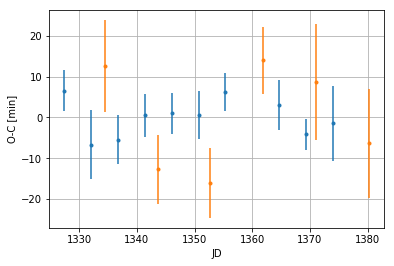

In [44]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

b_times = np.load('52368076/transit_times_b.npy')[0, :]
b_uncertainties = np.load('52368076/transit_times_b.npy')[1, :]
b_epoch = np.arange(len(b_times)) #np.array([0, 1, 2, 3, 4, 5, 7, 8, 9, 10])

# Skip the outlier b's transit times
trick_slice = np.r_[0:7,8:11]
b_times = b_times[trick_slice]
b_uncertainties = b_uncertainties[trick_slice]
b_epoch = b_epoch[trick_slice]

c_times = np.load('52368076/transit_times_c.npy')[0, :]
c_uncertainties = np.load('52368076/transit_times_c.npy')[1, :]
c_epoch = np.arange(len(c_times))

plt.errorbar(b_times, 24*60*(b_times - np.polyval(np.polyfit(b_epoch, b_times, 1), b_epoch)), 24*60*b_uncertainties, fmt='.')
plt.errorbar(c_times, 24*60*(c_times - np.polyval(np.polyfit(c_epoch, c_times, 1), c_epoch)), 24*60*c_uncertainties, fmt='.')

plt.xlabel('JD')
plt.ylabel('O-C [min]')
plt.grid()
#plt.savefig('o-c.png', dpi=250, bbox_inches='tight')

In [45]:
from astropy.constants import G, M_sun, R_sun
import astropy.units as u

def period_to_a(params, M_star=0.93*M_sun, R_star=0.892*R_sun): 
    return (((G * M_star / (4 * np.pi**2) * (params.per * u.day)**2)**(1/3)) / R_star).decompose().value

In [46]:
from batman import TransitParams, TransitModel

paramsb = TransitParams()
paramsb.per = 4.653811
paramsb.t0 = 2458327.432906 - 2457000
paramsb.duration = 2.9/24
paramsb.rp = np.sqrt(1007.882466 * 1e-6)
paramsb.a  = period_to_a(paramsb)
paramsb.u = [0.5971, 0.1172]
paramsb.limb_dark = 'quadratic'
paramsb.w = 90
paramsb.inc = 90
paramsb.ecc = 0

paramsc = TransitParams()
paramsc.per = 9.150607
paramsc.inc = 90
paramsc.t0 = 2458334.45669 - 2457000
paramsc.duration = 2.9/24
paramsc.rp = np.sqrt(996.181819 * 1e-6)
paramsc.a = period_to_a(paramsc)
paramsc.u = [0.5971, 0.1172]
paramsc.limb_dark = 'quadratic'
paramsc.w = 90
paramsc.ecc = 0

In [47]:
from ttvfast import ttvfast
from ttvfast.models import Planet 
from astropy.constants import M_sun, M_earth
import numpy as np
import astropy.units as u

period_b_init = paramsb.per
period_c_init = paramsc.per

mass_b_init = 1 * float(M_earth/M_sun) 
mass_c_init = 1 * float(M_earth/M_sun) 

# b
a = period_to_a(paramsb)
b = 0

inclination_b = np.degrees(np.arccos(b/a))

# c
a = period_to_a(paramsc) 
b = 0

inclination_c = np.degrees(np.arccos(b/a))

In [48]:
phase = 360 * (((b_times.min() - c_times.min())/period_c_init) % 1 )
phase_init_b = 0
phase_init_c = phase

b = Planet(mass=mass_b_init, period=period_b_init, eccentricity=0, inclination=inclination_b, 
           longnode=0, argument=90, mean_anomaly=phase_init_b)
c = Planet(mass=mass_c_init, period=period_c_init, eccentricity=0, inclination=inclination_c, 
           longnode=0, argument=90, mean_anomaly=phase_init_c)
result = ttvfast(planets=[b, c], stellar_mass=0.305, time=b_times.min(), dt=period_b_init/100, total=b_times.min()+100)
planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
condition = (times != -2)
planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]

indices_b = (planet_ind == 0) & np.in1d(epoch, b_epoch)
indices_c = (planet_ind == 1) & np.in1d(epoch, c_epoch)

epoch_c = epoch[indices_c]
model_times_b = times[indices_b]
model_times_c = times[indices_c]

model_times_b - b_times, model_times_c - c_times

(array([ 1.35969458e-10,  8.32492960e-03,  6.54718158e-03,  1.53807155e-03,
         2.39213670e-04, -2.98031092e-04, -5.20901640e-03, -4.79769806e-03,
        -6.66400289e-04, -3.56973357e-03]),
 array([-0.00043736,  0.01929494,  0.0238589 ,  0.00522813,  0.01106637,
         0.02382346]))

In [49]:
from astropy.constants import M_earth, M_sun

In [50]:
from astropy.constants import G, M_sun, R_sun
R_star = 0.291 * R_sun
R_b = paramsb.rp * R_star
R_c = paramsc.rp * R_star

In [51]:
R_b, R_c

(<Quantity 6427172.22064197 m>, <Quantity 6389756.34632871 m>)

In [52]:
import emcee
from corner import corner

M_starM_sun = 0.93
M_star = M_starM_sun * M_sun
a_b = ( ( (G * M_star)/(4 * np.pi**2) * (period_b_init*u.day)**2 )**(1/3) ).decompose()
a_c = ( ( (G * M_star)/(4 * np.pi**2) * (period_c_init*u.day)**2 )**(1/3) ).decompose()
 
rho_iron = 7.86 # g/cm**3

def lnprob(p):
    mass_b, mass_c, period_b, period_c, lam_b, lam_c, w_b, w_c = p

    rho_b = (mass_b * M_sun / (4/3 * np.pi * R_b**3)).to(u.g/u.cm**3).value
    rho_c = (mass_c * M_sun / (4/3 * np.pi * R_c**3)).to(u.g/u.cm**3).value

    if (mass_b < 0 or mass_c < 0 or lam_b > 360 or lam_b < 0
         or lam_c > 360 or lam_c < 0 or 
         w_b > 360 or w_b < 0 or w_c > 360 or w_c < 0 or 
         rho_b > rho_iron or rho_c > rho_iron): 
        return -np.inf
    
    ecc_b = 0
    ecc_c = 0
    
    # Hill stability criterion from Gladman 1993 Eqn. 21 for planets b and c
    gamma1 = np.sqrt(1 - ecc_b**2)
    gamma2 = np.sqrt(1 - ecc_c**2)
    mu1 = mass_b * M_starM_sun
    mu2 = mass_c * M_starM_sun
    alpha = mu1 + mu2
    Delta = (a_c - a_b)/a_b
    delta = np.sqrt(1 + Delta)
    
    if (alpha**-3 * (mu1 + mu2/delta**2)*(mu1*gamma1 + mu2*gamma2*delta)**2 <= 
        1 + 3**(4/3) * (mu1 * mu2) / alpha**(4/3)):
        return -np.inf
    
    b = Planet(mass=mass_b, period=period_b, eccentricity=0, inclination=inclination_b, 
               longnode=lam_b, argument=90, mean_anomaly=w_b)
    c = Planet(mass=mass_c, period=period_c, eccentricity=0, inclination=inclination_c, 
               longnode=lam_c, argument=90, mean_anomaly=w_c)
    result = ttvfast(planets=[b, c], stellar_mass=M_starM_sun, time=b_times.min(), 
                     dt=period_b_init/30, total=b_times.min()+100)
    planet_ind, epoch, times, rsky, vsky = [np.array(i) for i in result['positions']]
    condition = (times != -2)
    planet_ind, epoch, times, rsky, vsky = [i[condition] for i in [planet_ind, epoch, times, rsky, vsky]]
    
    # Parse results for planets e and f
    indices_b = (planet_ind == 0) & np.in1d(epoch, b_epoch)
    indices_c = (planet_ind == 1) & np.in1d(epoch, c_epoch)

    epoch_b = epoch[indices_b]
    epoch_c = epoch[indices_c]

    model_times_b = times[indices_b]
    model_times_c = times[indices_c]

    # Compute chi^2 for transit times of e and f    
    logchi2_b = -0.5 * np.sum( (model_times_b - b_times)**2 / b_uncertainties**2 )
    logchi2_c = -0.5 * np.sum( (model_times_c - c_times)**2 / c_uncertainties**2 )
    
    # Add log prior for planet mass from Gaia + forecaster
#     lnprior = (-0.5 * (mass_b - mass_b_init)**2 / mass_b_init_err**2
#                -0.5 * (mass_c - mass_c_init)**2 / mass_c_init_err**2)
    return logchi2_b + logchi2_c

ndim, nwalkers = 8, 50

init_masses = [mass_b_init, mass_c_init, 
               period_b_init, period_c_init, 0, 0, 
               phase_init_b, phase_init_c]

p0 = [init_masses + 1e-8 * np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, threads=8)
p1 = sampler.run_mcmc(p0, 10000)[0];
sampler.reset()
p2 = sampler.run_mcmc(p1, 10000);

/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/Users/bmmorris/anaconda/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


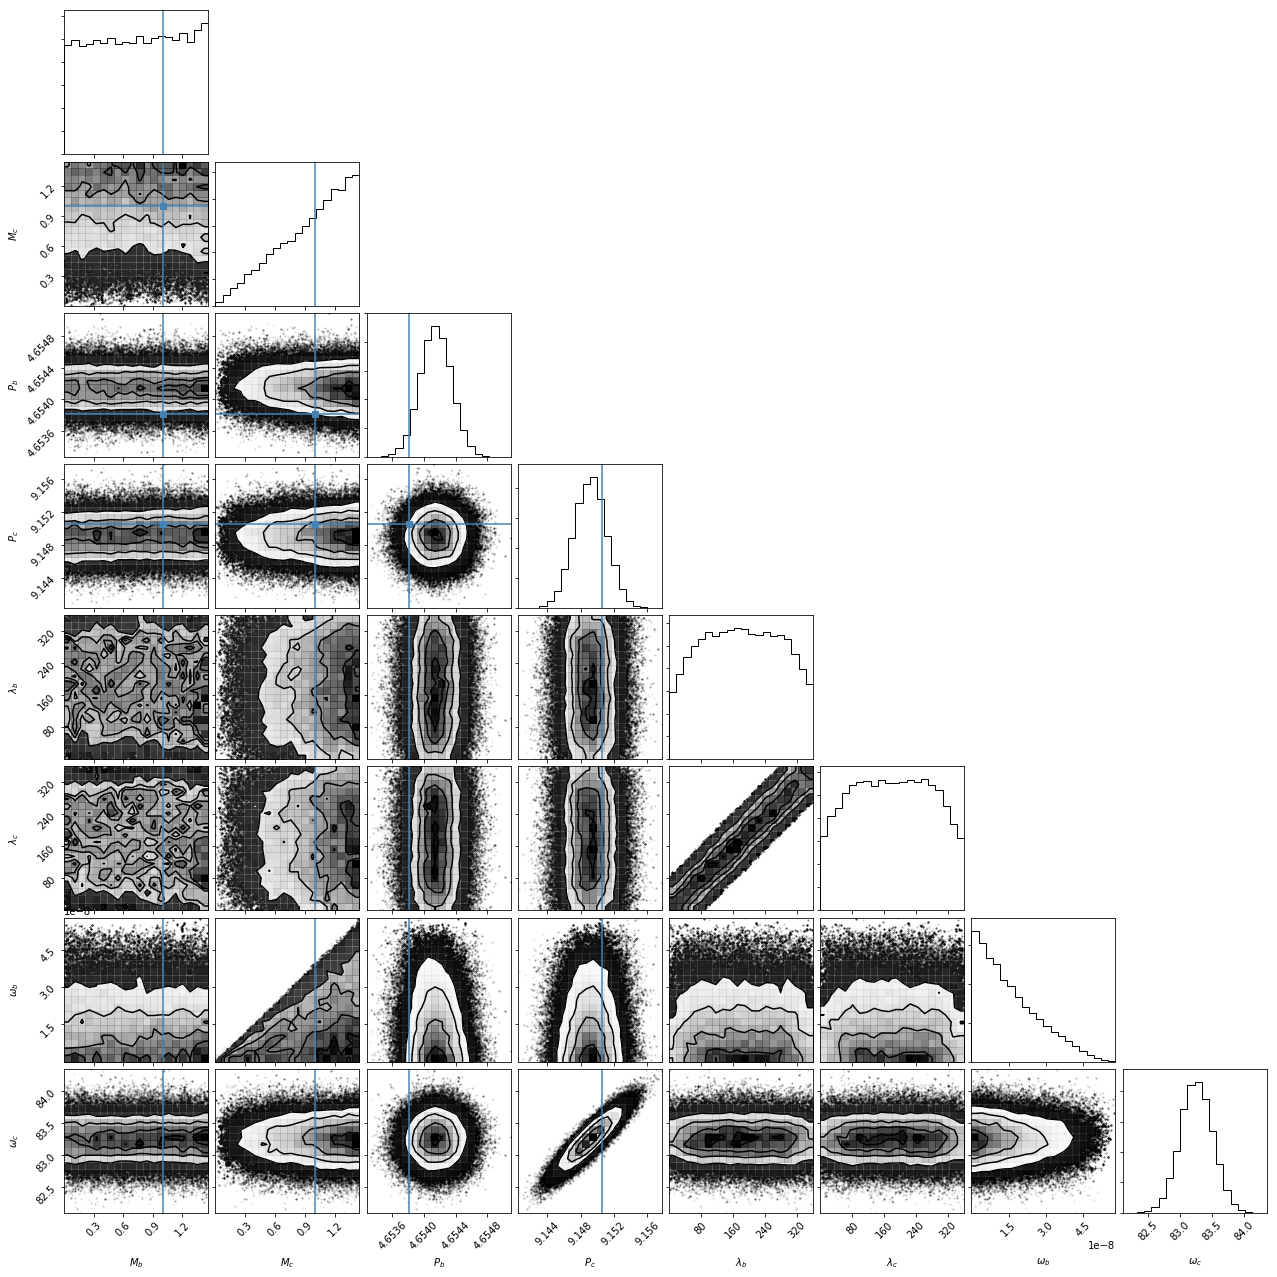

In [53]:
chains = np.copy(sampler.flatchain)
chains[:, :2] /= float(M_earth/M_sun)

corner(chains, 
       truths=[mass_b_init/float(M_earth/M_sun), mass_c_init/float(M_earth/M_sun), 
               period_b_init, period_c_init, 
               None, None, None, None], 
       labels=['$M_b$', '$M_c$', "$P_b$", "$P_c$", '$\lambda_b$', "$\lambda_c$",
                "$\omega_b$", "$\omega_c$"]);
plt.savefig('ttv_recovery_toi125.png', bbox_inches='tight', dpi=300)

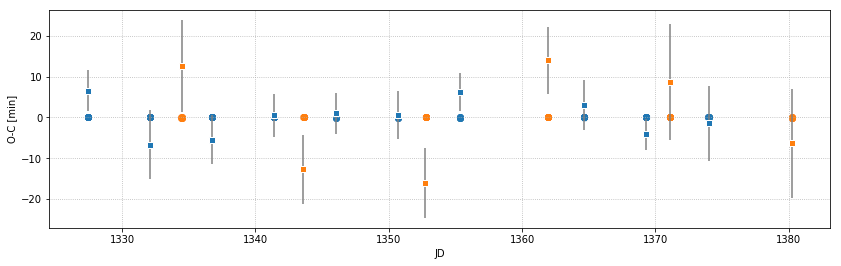

In [54]:
linear_ephem_b = np.polyval(np.polyfit(b_epoch, b_times, 1), b_epoch)
linear_ephem_c = np.polyval(np.polyfit(c_epoch, c_times, 1), c_epoch) 

plt.figure(figsize=(14, 4))
plt.errorbar(b_times, 24*60*(b_times - linear_ephem_b), 24*60*b_uncertainties, fmt='s', mec='w', ecolor='gray', color='C0')
plt.errorbar(c_times, 24*60*(c_times - linear_ephem_c), 24*60*c_uncertainties, fmt='s', mec='w', ecolor='gray', color='C1')

for i in range(100): 
    random_step = np.random.randint(sampler.flatchain.shape[0])

# for i in range(1):
#     random_step = np.argmax(sampler.flatlnprobability)
    mass_b, mass_c, period_b, period_c, lam_b, lam_c, w_b, w_c = sampler.flatchain[random_step, :]

    b = Planet(mass=mass_b, period=period_b, eccentricity=0, inclination=90, 
               longnode=lam_b, argument=90, mean_anomaly=w_b)
    c = Planet(mass=mass_c, period=period_c, eccentricity=0, inclination=90, 
               longnode=lam_c, argument=90, mean_anomaly=w_c)
    result = ttvfast(planets=[b, c], stellar_mass=M_starM_sun, time=b_times.min(), 
                     dt=period_b_init/30, total=b_times.min()+2500)
    planet_ind, epoch, times = [np.array(i) for i in result['positions'][:-2]]
    ignore_condition = (times != -2)
    planet_ind, epoch, times = [i[ignore_condition] for i in [planet_ind, epoch, times]]#, rsky, vsky]]
    
    # Parse results for planets e and f
    indices_b = (planet_ind == 0) & np.in1d(epoch, b_epoch)
    indices_c = (planet_ind == 1) & np.in1d(epoch, c_epoch)
    epoch_b = epoch[indices_b]
    epoch_c = epoch[indices_c]
    model_times_b = times[indices_b]
    model_times_c = times[indices_c]

    model_linear_ephem_b = np.polyval(np.polyfit(b_epoch, model_times_b, 1), b_epoch)
    model_linear_ephem_c = np.polyval(np.polyfit(c_epoch, model_times_c, 1), c_epoch) 
    
    plt.scatter(model_times_b, 24*60*(model_times_b - model_linear_ephem_b), alpha=0.05, color='C0')
    plt.scatter(model_times_c, 24*60*(model_times_c - model_linear_ephem_c), alpha=0.05, color='C1')
plt.xlabel('JD')
plt.ylabel('O-C [min]')
# plt.ylim([-2, 2])
# plt.xlim([2457300, 2458000])
plt.grid(ls=":")
# plt.savefig('o-c.png', bbox_inches='tight', dpi=200)